## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\laogoon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
# Hint 1 : 在 Dense 層中增加 Regularizers
from keras.regularizers import l1, l2, l1_l2
# Hint 2 : 增加 Dropout 層並設定 dropout ratio
from keras.layers import Dropout
# Hint 3 : 增加 Batch-normalization 層
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=0.001, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [15]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-6, 1e-8]
Dropout_EXP = 0.25

In [16]:
results = {}
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.8f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio, drp_ratio=Dropout_EXP)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulizer = 0.01000000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2

50000/50000 [==============================] - 3s 52us/step - loss: 1.6823 - acc: 0.4372 - val_loss: 1.7070 - val_acc: 0.4323
Epoch 47/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.6799 - acc: 0.4378 - val_loss: 1.6374 - val_acc: 0.4556
Epoch 48/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.6683 - acc: 0.4419 - val_loss: 1.6479 - val_acc: 0.4442
Epoch 49/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.6588 - acc: 0.4466 - val_loss: 1.6918 - val_acc: 0.4342
Epoch 50/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.6556 - acc: 0.4458 - val_loss: 1.7474 - val_acc: 0.4133
Experiment with Regulizer = 0.00010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dens

Epoch 42/50
50000/50000 [==============================] - 3s 51us/step - loss: 1.4897 - acc: 0.5096 - val_loss: 1.5072 - val_acc: 0.5112
Epoch 43/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.4842 - acc: 0.5139 - val_loss: 1.5289 - val_acc: 0.5033
Epoch 44/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.4906 - acc: 0.5122 - val_loss: 1.5326 - val_acc: 0.4972
Epoch 45/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.4773 - acc: 0.5185 - val_loss: 1.5020 - val_acc: 0.5067
Epoch 46/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.4691 - acc: 0.5195 - val_loss: 1.5482 - val_acc: 0.4959
Epoch 47/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.4662 - acc: 0.5199 - val_loss: 1.5177 - val_acc: 0.5073
Epoch 48/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.4705 - acc: 0.5168 - val_loss: 1.5118 - val_acc: 0.5102
Epoch 49/50
50000/50000 [=========

Epoch 38/50
50000/50000 [==============================] - 3s 55us/step - loss: 1.3764 - acc: 0.5088 - val_loss: 1.3837 - val_acc: 0.5062
Epoch 39/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.3679 - acc: 0.5071 - val_loss: 1.3760 - val_acc: 0.5109
Epoch 40/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.3683 - acc: 0.5064 - val_loss: 1.3605 - val_acc: 0.5133
Epoch 41/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.3593 - acc: 0.5105 - val_loss: 1.3865 - val_acc: 0.5018
Epoch 42/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.3527 - acc: 0.5132 - val_loss: 1.3880 - val_acc: 0.5075
Epoch 43/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.3543 - acc: 0.5136 - val_loss: 1.3633 - val_acc: 0.5123
Epoch 44/50
50000/50000 [==============================] - 3s 58us/step - loss: 1.3376 - acc: 0.5195 - val_loss: 1.3589 - val_acc: 0.5094
Epoch 45/50
50000/50000 [=========

Epoch 34/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.3915 - acc: 0.5018 - val_loss: 1.3978 - val_acc: 0.5033
Epoch 35/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.3908 - acc: 0.5005 - val_loss: 1.3868 - val_acc: 0.5046
Epoch 36/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.3885 - acc: 0.5027 - val_loss: 1.3814 - val_acc: 0.5022
Epoch 37/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.3811 - acc: 0.5014 - val_loss: 1.3757 - val_acc: 0.5031
Epoch 38/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.3780 - acc: 0.5060 - val_loss: 1.3916 - val_acc: 0.5004
Epoch 39/50
50000/50000 [==============================] - 3s 50us/step - loss: 1.3752 - acc: 0.5053 - val_loss: 1.3868 - val_acc: 0.4973
Epoch 40/50
50000/50000 [==============================] - 2s 50us/step - loss: 1.3699 - acc: 0.5097 - val_loss: 1.4392 - val_acc: 0.4849
Epoch 41/50
50000/50000 [=========

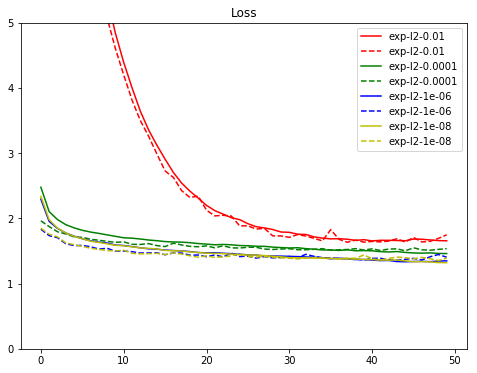

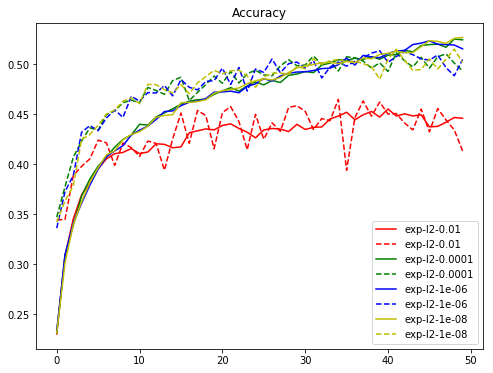

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()